# Get the data

In [2]:
import nltk

In [3]:
import pandas as pd

We'll use read_csv and make note of the sep argument, we can also specify the desired column names by passing in a list of names.

In [4]:
data=pd.read_csv(r"SMSSpamCollection.csv",sep="\t",names=["Labels","messages"])

In [5]:
data.head()

,Labels,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis
Let's check out some of the stats with some plots and the built-in methods in pandas!

In [6]:
data.describe()

,Labels,messages
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Labels      5572 non-null object
messages    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


Let's use groupby to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [8]:
data.groupby("Labels").describe()

messages                                                               
          count unique                                                top freq
Labels                                                                        
ham        4825   4516                             Sorry, I'll call later   30
spam        747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [9]:
data["length"]=data["messages"].apply(len)
data.head()

,Labels,messages,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


# Data Visualization

Let's visualize this! Let's do the imports:

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

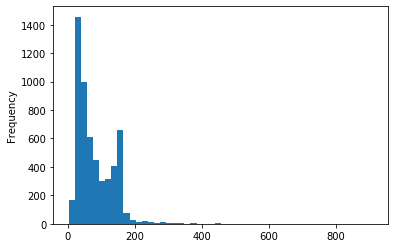

In [11]:
data['length'].plot(bins=50, kind='hist')

Play around with the bin size! Looks like text length may be a good feature to think about! Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [12]:
data.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [13]:
data[data["length"]==910]

,Labels,messages,length
1085,ham,For me the love should start with attraction.i...,910


In [14]:
data[data["length"]==910]["messages"]

1085    For me the love should start with attraction.i...
Name: messages, dtype: object

In [15]:
data[data["length"]==910]["messages"].iloc[0] #masking to print the message

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [16]:
data[data["length"]==2]["messages"].iloc[0]

'Ok'

# Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [17]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Check characters to see if they are in punctuation
nopunc = [char for char in mess if char not in string.punctuation]

# Join the characters again to form the string.
nopunc = ''.join(nopunc)

In [18]:
nopunc

'Sample message Notice it has punctuation'

Now let's see how to remove stopwords. We can impot a list of english stopwords from NLTK (check the documentation for more languages and info).

In [19]:
from nltk.corpus import stopwords

In [20]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
nopunc

'Sample message Notice it has punctuation'

In [22]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [23]:
clean_mess=[char for char in nopunc.split() if char not in stopwords.words('English')]

In [24]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

In [25]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [26]:
data.head()

,Labels,messages,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [27]:
data["messages"].head().apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: messages, dtype: object

# Vectorization

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
CV=CountVectorizer()

In [30]:
data_vec=CV.fit(data["messages"])

In [31]:
print(len(data_vec.vocabulary_))

8713


In [32]:
vec=CV.transform(data["messages"])

In [33]:
vec.shape

(5572, 8713)

In [34]:
vec.nnz

74169

In [35]:
print(vec)

  (0, 1082)	1
  (0, 1316)	1
  (0, 1765)	1
  (0, 1767)	1
  (0, 2061)	1
  (0, 2338)	1
  (0, 3571)	1
  (0, 3615)	1
  (0, 3655)	1
  (0, 4114)	1
  (0, 4374)	1
  (0, 4501)	1
  (0, 5571)	1
  (0, 5958)	1
  (0, 7694)	1
  (0, 8084)	1
  (0, 8324)	1
  (0, 8548)	1
  (1, 4342)	1
  (1, 4537)	1
  (1, 5538)	1
  (1, 5567)	1
  (1, 8450)	1
  (2, 77)	1
  (2, 403)	1
  :	:
  (5570, 1794)	1
  (5570, 1802)	1
  (5570, 2606)	1
  (5570, 2905)	1
  (5570, 3323)	1
  (5570, 3373)	1
  (5570, 3489)	1
  (5570, 3709)	1
  (5570, 3805)	1
  (5570, 4114)	1
  (5570, 4188)	1
  (5570, 4245)	1
  (5570, 4642)	1
  (5570, 5367)	1
  (5570, 7089)	1
  (5570, 7099)	1
  (5570, 7674)	1
  (5570, 7806)	1
  (5570, 8120)	1
  (5570, 8371)	1
  (5571, 4253)	2
  (5571, 5276)	1
  (5571, 6548)	1
  (5571, 7806)	1
  (5571, 7938)	1


In [36]:
from sklearn.feature_extraction.text import TfidfTransformer

In [37]:
Tf=TfidfTransformer()

In [38]:
term=Tf.fit_transform(vec)

In [39]:
print(term)

  (0, 8548)	0.22083291550052703
  (0, 8324)	0.18241264829651851
  (0, 8084)	0.23001810878216972
  (0, 7694)	0.1555161950550194
  (0, 5958)	0.25535167546045223
  (0, 5571)	0.15602976712614566
  (0, 4501)	0.27580485521143805
  (0, 4374)	0.32647198856800297
  (0, 4114)	0.1069931616636402
  (0, 3655)	0.18034330636364296
  (0, 3615)	0.15305130991688437
  (0, 3571)	0.14787418026870422
  (0, 2338)	0.25283008183768235
  (0, 2061)	0.27580485521143805
  (0, 1767)	0.27580485521143805
  (0, 1765)	0.3116528020516887
  (0, 1316)	0.24419040033995174
  (0, 1082)	0.32647198856800297
  (1, 8450)	0.43162957585464123
  (1, 5567)	0.5466243141314314
  (1, 5538)	0.2718944069420321
  (1, 4537)	0.4083258549263009
  (1, 4342)	0.5236804332035243
  (2, 8506)	0.1868521848510181
  (2, 8463)	0.1448601166108939
  :	:
  (5570, 7099)	0.20541570643501375
  (5570, 7089)	0.18433209615766674
  (5570, 5367)	0.2101107882421641
  (5570, 4642)	0.159545141701127
  (5570, 4245)	0.12207280777305733
  (5570, 4188)	0.28301955592729

In [51]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(data['messages'], data['Labels'], test_size=0.2)

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
])


In [52]:
text_clf.fit(msg_train,label_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [55]:
predicted=text_clf.predict(msg_test)

In [57]:
import numpy as np 
np.mean(predicted==label_test)

0.967713004484305